# Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters (not just partition of the sample into disjoint sets, but a system of nested partitions).

There are two stategies for hierachy clustering:
* **Divisive** or top-down algorithms split the sample into smaller and smaller clusters
* **Agglomerative** or bottom-up algorithms, in which objects are combined into larger and larger clusters
 
```{image} ./assets/aglo_and_divisive.jpeg
:width: 600px
:align: center
```

The agglomerative approach is more popular and effective. The algorithm itself looks pretty simple and consists of the following steps:
* **Initialization:** Create as many clusters as there are objects, each object in its own separate cluster.
* **Repeat:** Do following steps until the stopping criterion is met
  - **Compute distances:** Calculate the pairwise distance or similarity between each pair of clusters.
  - **Merging:** Combine of the two closest clusters into a new cluster.


In [5]:
from jupyterquiz import display_quiz
q_demo_seq = [{
    "question": "Imagine, we run this algorithm till we have one big cluster which includes all $N$ samples. Using the naive approach what is the number of operations required for this? ",
    "type": "multiple_choice",
       "answers": [
        {"answer": "$\\mathcal{O}(N^2)$", "correct": False, "feedback": "Oops! It's not correct! Try again."}, 
        {"answer": "$\\mathcal{O}(N^3)$", "correct": True, "feedback": "The number of iterations can be at most $N−1$ (because in each iteration, we merge two clusters and reduce the total number of clusters by one). At each iteration we compute pairwise distance between each clusters and find closest pair, which requires $\mathcal{O}(n^2)$ operations. Therefore, the worst-case time complexity for the naive agglomerative hierarchical clustering algorithm is $\mathcal{O}(N * N^2)$ = $\mathcal{O}(N^3)$."}, 
        {"answer": "$\\mathcal{O}(N)$", "correct": False, "feedback": "Oops! It's not correct! Try again."}, 
        {"answer": "$\\mathcal{O}(N^2 \log N)$", "correct": False, "feedback": "Oops! It's not correct! Try again."}]}]
display_quiz(q_demo_seq)

<IPython.core.display.Javascript object>

<div style="display:none" id="question2">[{"question": "What are the two main types of hierarchical clustering?", "type": "multiple_choice", "answers": [{"answer": "Agglomerative Clustering", "correct": true, "feedback": "Exactly!"}, 
 {"answer": "Divisive Clustering", "correct": true, "feedback": "Exactly!"}, 
{"answer": "K-means Clustering", "correct": false, "feedback": "Oops! It's not correct! Try again."}, 
{"answer": "K-medoids Clustering", "correct": false, "feedback": "Oops! It's not correct! Try again."}]}]</div> 
<div style="display:none" id="question4">[{"question": "Which linkage method is based on the distance between the closest points of two clusters?", "type": "multiple_choice", "answers":[{"answer": "Single Linkage", "correct": true, "feedback": "Explanation: Single linkage in hierarchical clustering is the minimum distance between data points in two clusters."}, 
{"answer": "Complete Linkage", "correct": false, "feedback": "Oops! It's not correct! Try again."}, 
{"answer": "Ward's Method", "correct": false, "feedback": "Oops! It's not correct! Try again."},
{"answer": "Unweighted Pair Group Method with Centroid average (UPGMC)", "correct": false, "feedback": "Oops! It's not correct! Try again."}]}]</div> 
<div style="display:none" id="question5">[{"question": "In the context of hierarchical clustering, what does a dendrogram visualize?", "type": "multiple_choice", "answers": [{"answer": "The distribution of data points in the feature space.", "correct": false, "feedback": "Oops! It's not correct! Try again."}, 
{"answer": "The hierarchy of clusters and the merging order.", "correct": true, "feedback": "Exactly!"}, 
{"answer": "The average distance between clusters.", "correct": false, "feedback": "Oops! It's not correct! Try again."}, 
{"answer": "A diagram that represents the density of clusters.", "correct": false, "feedback": "Oops! It's not correct! Try again."}]}]</div> 

In [6]:
display_quiz("#question2")

<IPython.core.display.Javascript object>

<div style="display:none" id="question6">[{"question": "How many strategies are there for hierarchical clustering? Enter the numeric answer.", "type": "numeric", "answers": [{
                "type": "value",
                "value": 2,
                "correct": true,
                "feedback": "Correct."
            }, 
            {
                "type": "default",
                "feedback": "Try again."
            }]}]</div> 
<div style="display:none" id="question7">[{"question": "How many linkage methods are described for identifying closest clusters? Enter the numeric answer.", "type": "numeric", "answers": [{
                "type": "value",
                "value": 5,
                "correct": true,
                "feedback": "Correct."
            }, 
            {
                "type": "default",
                "feedback": "Try again."
            }]}]</div> 

## Distance Matrix and its calculation

The main data structure used by hierarchical clustering algorithms, which allows them to keep track of distances between clusters, is the **distance matrix**.

Formally, if the dataset has n data points $\{x_1, \ldots, x_n\}$, a distance matrix $D$ is an $n \times n$ matrix, where $D_{i j}$ is the distance between points $x_{i}$ and $x_{j}$. By definition, the distance matrix is symmetric and its diagonal entries are all zeros.

Usually, the distance between two data points $x, y \in\mathbb R^d$ is calculated with metrics such as:

* **Euclidean distance:** $\hspace{2mm} \rho(x, y)=\sqrt{\sum\limits_{i=1}^d(x_i - y_i)^2}$
  
* **Squared Euclidean distance:** $\hspace{2mm} \rho(x, y)=\sum\limits_{i=1}^d(x_i - y_i)^2$

* **Manhattan Distance:** $\hspace{2mm} \rho(x, y)=\sum\limits_{i=1}^d |x_i - y_i|$
  
* **Cosine Distance:** $\hspace{2mm} \rho(x, y)=\frac{\sum\limits_{i=1}^dx_i y_i}{\sqrt{\sum\limits_{i=1}^dx_i^2}\sqrt{\sum\limits_{i=1}^dy_i^2}}$

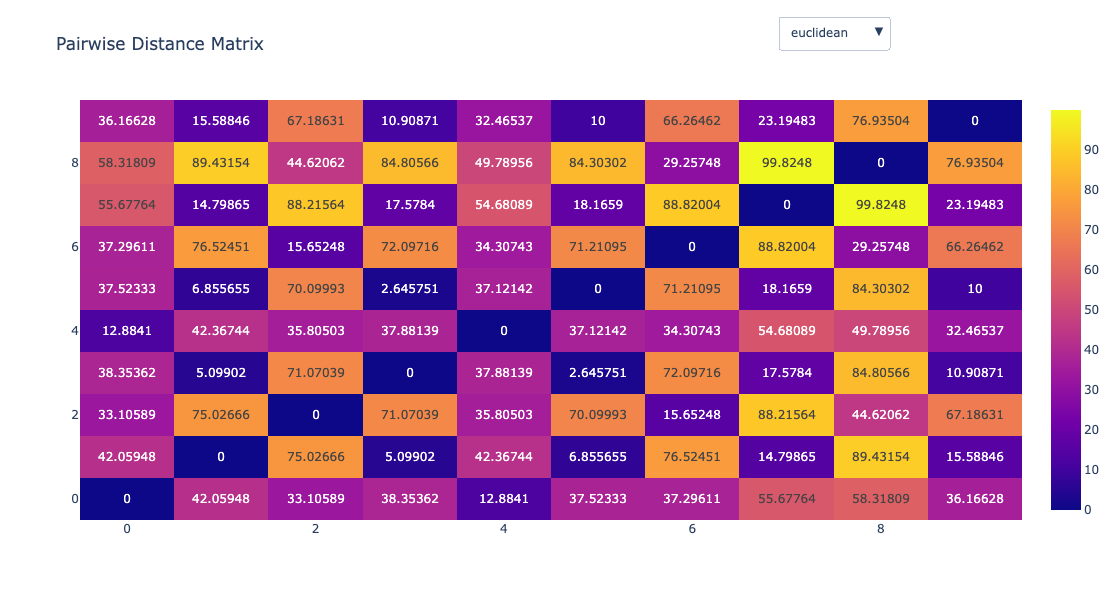

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist, squareform
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_distance_heatmap(df, metric_name):
    distances = pdist(df, metric=metric_name)
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=df.index, columns=df.index)

    # Create a pretty heatmap using Seaborn
    fig = px.imshow(distance_df, labels=dict(x='Index', y='Index', color='Distance'),
                    x=distance_df.index, y=distance_df.columns, color_continuous_scale="viridis",text_auto=True)

    fig.update_layout(title=f'Pairwise Distance Matrix for {metric_name.capitalize()} Method',
                      xaxis_title='Index', yaxis_title='Index')

    print(fig.frames)

    fig.show()


# Load the Mall Customer Segmentation Data
df_mall = pd.read_csv("assets/mall_customers.csv")
gender_mapping = {'Male': 1, 'Female': 0}

# Apply the mapping to the 'Gender' column
df_mall['Gender'] = df_mall['Gender'].map(gender_mapping)
df_mall = df_mall.head(10)

# Select numeric columns
df_numeric = df_mall.select_dtypes(include=['number'])

# Check for missing values and fill if necessary
df_numeric.fillna(0, inplace=True)

# Create a dropdown widget for selecting metrics
# metric_dropdown = widgets.Dropdown(options=['euclidean', 'sqeuclidean', 'cosine', 'correlation'], value='euclidean', description='Select Metric:')

# # Create an interactive plot
# def update_plot(selected_metric):
#     plot_distance_heatmap(df_numeric, selected_metric)

# widgets.interactive(update_plot, selected_metric=metric_dropdown)

fig = go.Figure()

for idx, metric in enumerate(['euclidean', 'sqeuclidean', 'cosine', 'cityblock']):
    distances = pdist(df_numeric, metric=metric)
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=df_numeric.index, columns=df_numeric.index)

    heatmap = px.imshow(distance_df, labels=dict(x='Index', y='Index', color='Distance'),
                    x=distance_df.index, y=distance_df.columns, color_continuous_scale="viridis",text_auto=True)

    # fig.update_layout(title=f'Pairwise Distance Matrix for {metric_name.capitalize()} Method',
    #                   xaxis_title='Index', yaxis_title='Index')

    for data in heatmap.data:
        data.visible=False
        fig.add_trace(data)

fig.data[0].visible = True

# fig.update_layout(title='Pairwise Distance Matrix', axis_title='Index', yaxis_title='Index')

fig.update_layout(
    height=600,
    width=600,
    title="Pairwise Distance Matrix",
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[
                        # {"type": "heatmap"},
                        {"visible": [True, False, False, False]}
                    ],
                    label="euclidean",
                    method="update",
                ),
                dict(
                    args=[
                        # {"type": "heatmap"},
                        {"visible": [False, True, False, False]}
                    ],
                    label="sqeuclidean",
                    method="update",
                ),
                dict(
                    args=[
                        # {"type": "heatmap"},
                        {"visible": [False, False, True, False]}
                    ],
                    label="cosine",
                    method="update",
                ),
                dict(
                    args=[
                        # {"type": "heatmap"},
                        {"visible": [False, False, False, True]}
                    ],
                    label="manhattan",
                    method="update",
                )
            ]),
            direction="down",
            active=0,
            showactive=True,
            x=0.8,
            xanchor="center",
            y=1.2,
            yanchor="top",
        ),
    ]
)

    
fig.show()

In [8]:
q_demo_seq = [{
    "question": "Given two objects represented by tuples $(3, 5)$ and $(2, 0)$. What is the Euclidean distance between two objects?",
    "type": "multiple_choice",
    "answers": [
        {"answer": "5", "correct": False, "feedback": "Oops! It's not correct! Try again."}, 
        {"answer": "5.1", "correct": True, "feedback": "Exactly! By calculating $d=\\sqrt{\\sum_{i=1}^{n}(v_i - u_i)^2}$ we get $d = \\sqrt{(2 - 3)^2 + (0 - 5)^2}\\approx5.1$"}, 
        {"answer": "6", "correct": False, "feedback": "Oops! It's not correct! Try again."}, 
        {"answer": "None of the above", "correct": False, "feedback": "Oops! It's not correct! Try again."}]}]
display_quiz(q_demo_seq)

<IPython.core.display.Javascript object>

## Linkage and Distance

At first, each object is considered as one cluster. For single element clusters, the distance function is naturally defined:

$R(\{x\},\{y\})=\rho (x, y)$

The distances between objects $\rho$ can be specified by any metric listed above.
Then the process of clusters merging starts. At each iteration, instead of the pair of closest clusters $U$ and $V$, a new cluster $W = U \cup V$ is formed. There are several methods of identifing closest clusters:

* **Single linkage aka Nearest Point Algorithm:** The distance between clusters is defined by the distance between their closest members.

```{image} ./assets/single.jpeg
:width: 400px
:align: center
```

$$\hspace{2mm} R_{min}(U, V)=\min\limits_{u \in U, v \in V}\rho (u, v)$$


* **Complete linkage aka Farthest Point Algorithm:** The distance between clusters is defined by the distance between their furthest members.

<!-- <img src="./assets/complete.jpeg" width="400"/> -->
```{image} ./assets/complete.jpeg
:width: 400px
:align: center
```

$$\hspace{2mm} R_{max}(U, V)=\max\limits_{u \in U, v \in V}\rho (u, v)$$


* **Unweighted Pair Group Method with Arithmetic mean (UPGMA):** Average-average distance or average linkage is the method that involves looking at the distances between all pairs and averages all of these distances. 


<!-- <img src="./assets/avg.jpeg" width="400"/> -->
```{image} ./assets/avg.jpeg
:width: 400px
:align: center
```

$$\hspace{2mm} R_{avg}(U, V)=\dfrac{1}{|U|\cdot|V|}\sum\limits_{u \in U}\sum\limits_{v \in V}\rho (u, v)$$


* **Unweighted Pair Group Method with Centroid average (UPGMC):** A point defined by the mean of all points (centroid) is calculated for each cluster and the distance between clusters is the distance between their respective centroids.


<!-- <img src="./assets/center.jpeg" width="400"/> -->
```{image} ./assets/center.jpeg
:width: 400px
:align: center
```

$$\hspace{2mm} R_{cen}(U, V)=\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})$$


* **Ward's method:** It is based on the increase in the sum of squared errors (ESS) that results from merging two clusters. It aims to minimize the variance within the newly formed cluster. The idea is to choose the pair of clusters for which the merging leads to the smallest increase in the total within-cluster sum of squares.


<!-- <img src="./assets/ward.jpeg" width="600"/> -->
```{image} ./assets/ward.jpeg
:width: 600px
:align: center
```

$$\hspace{2mm} R_{ward}(U, V)=\dfrac{|U|\cdot|V|}{|U|+|V|}\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})$$


<br></br>

At each step, it is good to be able to quickly calculate the distance from the formed cluster $W = U \cup V$ to any other cluster $S$, using known distances from previous steps. This is easily accomplished using the equation proposed by Lance and Williams in 1967:


$$R(W,S)=\alpha_{U}\cdot R(U,S)+\alpha_{V}\cdot R(V,S)+\beta\cdot R(U,V)+\gamma\cdot|R(U,S)−R(V,S)|$$

$$\alpha_{U}, \alpha_{V}, \beta, \gamma - \text{some parameters}$$


```{note}
:class: dropdown
For each of the above distance functions, compliance with the Lance-Williams equation has been proven for certain combinations of parameters
* Single linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=-0.5$

* Complete linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=0.5$
* UPGMA: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=0, \gamma=0$
* UPGMC: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=-\alpha_{U}\cdot \alpha_{V}, \gamma=0$
* Ward's method: $\alpha_{U}=\dfrac{|S|+|U|}{|S|+|W|}, \alpha_{V}=\dfrac{|S|+|V|}{|S|+|W|}, \beta=\dfrac{-|S|}{|S|+|W|}, \gamma=0$
```

In [9]:
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering

def predict_clusters(X, n_clusters=2, linkage='ward'):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    clusters = agg_clustering.fit_predict(X)
    return clusters

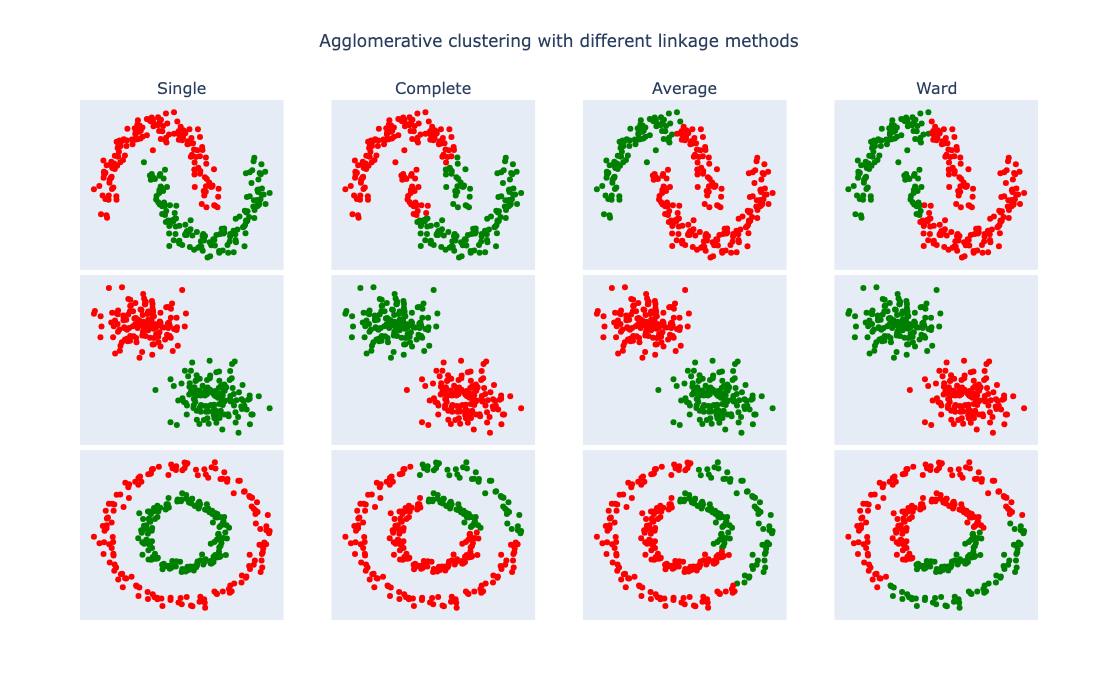

In [10]:
from sklearn.datasets import make_blobs, make_moons, make_circles

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=47)
X_blobs, y_blobs = make_blobs(n_samples=300, centers=2, cluster_std=2.0, random_state=107)
X_circs, y_circs = make_circles(n_samples=300, noise=0.05, random_state=47, factor=0.5)


fig = make_subplots(rows=3, cols=4, vertical_spacing=0.01, horizontal_spacing=0.05,
                    subplot_titles=("Single", "Complete", "Average", "Ward"))
linkage_methods = ['single', 'complete', 'average', 'ward']

def cluster2color(clusters):
    return ['red' if i == 0 else  'green' for i in clusters]

for idx, linkage_method in enumerate(linkage_methods):
    
    fig.add_trace(
        go.Scatter(
            x=X_moons[:, 0], 
            y=X_moons[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_moons, linkage=linkage_method))),
        ),
        row=1, col=idx+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=X_blobs[:, 0], 
            y=X_blobs[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_blobs, linkage=linkage_method))),
        ),
        row=2, col=idx+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=X_circs[:, 0], 
            y=X_circs[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_circs, linkage=linkage_method))),
        ),
        row=3, col=idx+1
    )

# for i in range(3):
#     fig.data[i].visible = True

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="right",
#             showactive=True,
#             x=0.5,
#             xanchor="center",
#             y=1.2,
#             yanchor="top",
#             buttons=list([
#                 dict(label=linkage_method,
#                      method="update",
#                      args=[{"visible": [False] * i * 3 + [True] * 3  + [False] * 3 * (4 - i)}])
#                 for i, linkage_method in enumerate(linkage_methods)
#             ]),
#         )
#     ]
# )

fig.update_layout(
    autosize=True,
    height=700,
    title={"text": "Agglomerative clustering with different linkage methods", "x": 0.5, "y": 0.95},
    showlegend=False,
)

fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.show()

## Pros and Cons

Each method has its pros, as they have their cons. Firstly let's you can see them bellow on table:

| Method          | Pros                                          | Cons    |
|---------------| ----------------------------------------------|--------|
| **Single linkage**       |• Can capture clusters of non-elliptical shapes, <br> such as elongated clusters or clusters with more complex geometries. <br> • Supports various distance metrics.|• Sensitive to noise and outliers. <br> • Prone to the “chaining” effect, where clusters <br> that are actually separate can be connected by a series <br> of intermediate points that act as bridges.  |
| **Complete linkage**        |• Less susceptible to noise and outliers. <br> • Supports various distance metrics.|• Could unite rather dissimilar groups at an early stage. <br> • Struggles to capture clusters of non-elliptical shape.|
| **UPGMA**       |• Provides a balance between single and complete linkage. <br> • Less sensitive to noise and outliers as compared to single linkage.|• Biased towards globular clusters.|
| **UPGMC**         |• Quite intuitive. <br> • Less sensitive to noise and outliers as compared to single linkage.|• Less suitable for capturing non-elliptical clusters. <br> • Can suffer from the “inversion phenomenon”, where <br> merging two clusters decreases their distance to other clusters. <br> • Supports only the Euclidean distance metric.|
| **Ward's method**          |• Tends to produce compact and equally-sized clusters (similar to k-means). <br> • Less sensitive to noise and outliers as compared to single linkage.|• Assumes that the clusters have approximately the same size. <br> • Less suitable for capturing non-elliptical clusters. <br> • Supports only the Euclidean distance metric.|

There is no exact answer to the question of which linkage algorithm is better. Each of the distances listed above has its own disadvantages and is not suitable for all tasks. But in compliance with the experience of most data scientists, it has been proven that **Ward's method** turned out to be the best according to the results of experimental comparison on a representative set of model problems. It recovers the intuitively best clustering more often than other methods.

In [11]:
display_quiz("#question4")

<IPython.core.display.Javascript object>

## Dendrogram
As clusters merge, each iteration of the algorithm corresponds to a pair of clusters merged at this iteration, as well as the distance between the clusters at the moment of merging. Distances will only increase with iteration, so it becomes possible to visualize the result in the form of a beautiful cluster tree called a **dendrogram**.

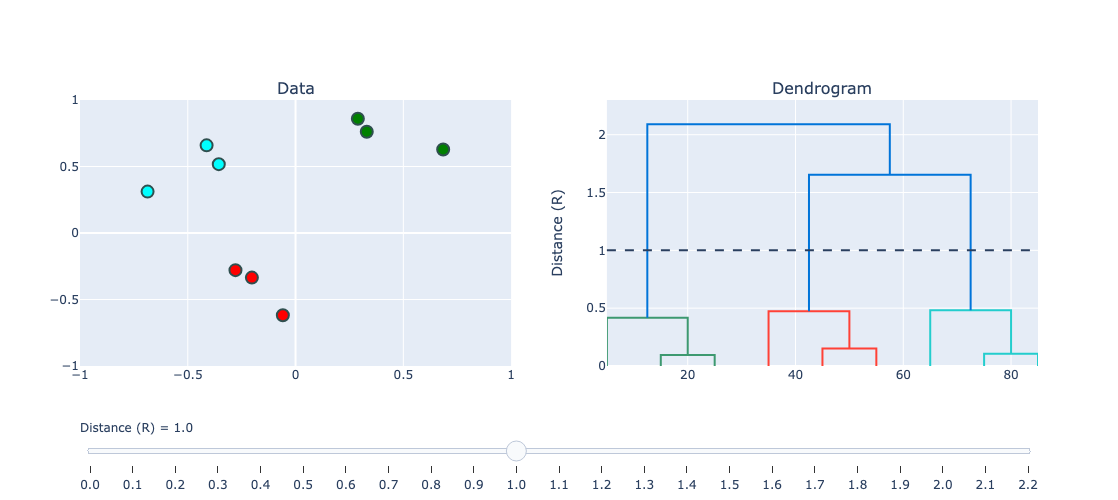

In [12]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import AgglomerativeClustering

X, y = make_blobs(n_samples=9, centers=[[0.5, 0.5], [0.0, -0.5], [-0.5, 0.5]], cluster_std=0.2, center_box=(-1, 1), random_state=47)

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1,
                    subplot_titles=("Data", "Dendrogram"))

colors = ["green", "red", "cyan", "blue", "pink", "grey", "orange", "white", "yellow"]

slider_vals = np.arange(0, 2.3, 0.1)

for idx, val in enumerate(slider_vals): 

    agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=val, linkage='ward')
        
    fig.add_trace(
        go.Scatter(
            x=X[:, 0], 
            y=X[:, 1], 
            mode='markers', 
            marker=dict(
                size=12, 
                color=[colors[i] for i in agg_clustering.fit_predict(X)],#[colors[i] for i in y],
                line=dict(width=2, color='DarkSlateGrey')
            ),
            visible=False
        ),
        row=1, col=1,
    )
    
    dendrogram = ff.create_dendrogram(
        X, labels=y,
        linkagefun=lambda x: linkage(x, method='ward'),
        color_threshold=val
    )
    
    for data in dendrogram.data:
        data.visible = False
        fig.add_trace(data, row=1, col=2)

    fig.add_hline(y=val, row=1, col=2, visible=False, line_dash="dash")

trace_cnt_per_val = len(fig.data) // len(slider_vals)


active = 10

for i in range(trace_cnt_per_val * active, trace_cnt_per_val * (active + 1)):
    fig.data[i].visible = True

fig.layout.shapes[active].visible = True

fig.update_layout(
    autosize=True,
    height=500,
    showlegend=False,
)

fig.update_layout(
    yaxis={'range': [-1.0, 1.0]},
    xaxis={'range': [-1.0, 1.0]}
)
fig.update_layout(
    yaxis2={'range': [0, 2.3], "title": "Distance (R)"}
)

fig.update_layout(
    sliders=[
        dict(
            active=active,
            pad={"t": 50},
            currentvalue={"prefix": "Distance (R) = "}, 
            steps=[
                dict(
                    method="update",
                    args=[
                        {"visible": [False] * i * trace_cnt_per_val + [True] * trace_cnt_per_val + [False] * (len(slider_vals) - i - 1) * trace_cnt_per_val},
                        {f"shapes[{j}].visible": (j == i) for j in range(len(slider_vals))}
                    ],
                    label=f"{val:.1f}"
                )
                for i, val in enumerate(slider_vals)
            ],
        )
    ],
)

# trace_cnt = []
# layouts = []

# linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']
# num_clusters = 2

# for linkage_method in linkage_methods:

#     dendrogram = ff.create_dendrogram(
#         X, labels=y,
#         linkagefun=lambda x: linkage(x, method=linkage_method)
#     )

#     trace_cnt.append(len(dendrogram.data))
    
#     for data in dendrogram.data:
#         data.visible = False
#         data.showlegend = False
#         fig.add_trace(data)

#     layouts.append(dendrogram.layout)

# fig.update_layout(
#     title={"text": "Dendrogram", "x": 0.5, "y": 0.95},
#     xaxis=layouts[0]["xaxis"],
#     yaxis=layouts[0]["yaxis"],
# )

# for i in range(trace_cnt[0]):
#     fig.data[i].visible = True

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="right",
#             active=0,
#             showactive=True,
#             x=0.5,
#             xanchor="center",
#             y=1.2,
#             yanchor="top",
#             buttons=list([
#                 dict(label=linkage_method,
#                      method="update",
#                      args=[
#                          {"visible": [False] * sum(trace_cnt[:i]) + [True] * trace_cnt[i]  + [False] * sum(trace_cnt[i:])},
#                          {
#                              "xaxis": layouts[i]["xaxis"], 
#                              "yaxis": layouts[i]["yaxis"],
#                              "autosize": False,
#                          }
#                      ]
#                     )
#                 for i, linkage_method in enumerate(linkage_methods)
#             ]),
#         )
#     ])

fig.show()

On the diagram above, the synthetic data is shown on the left, and the dendrogram itself based on this data is on the right. On the dendrogram, sample objects are marked along the horizontal axis, distances between clusters are plotted vertically. Cluster merges correspond to horizontal lines. 

We can set linkage distance threshold at or above which clusters will not be merged. Play with slider to understand how clusters change depending on threshold value.

```{admonition} Number of clusters
:class: tip
To determine the number of clusters, the interval of maximum length $|R_{t+1}−R_{t}|$ is found. The final clusters are the clusters obtained at step $t$. In this case, the number of clusters is equal to $m−t+1$. However, when the number of clusters is unknown in advance and there are not very many objects in the sample, it can be useful to look at full dendrogram.
```

In [13]:
display_quiz("#question5")

<IPython.core.display.Javascript object>

## Example: Iris Dataset

**About Dataset**:
The Iris flower dataset is a classic dataset in the field of machine learning and statistical analysis. It consists of 150 observations of iris flowers, including the sepal and petal length and width for each flower, as well as the species of the flower. 

**About Features**:

| Name             | Description                                          | 
|------------------| -----------------------------------------------------|
| **sepal_length**          | Sepal length, in centimeters, used as input.|
| **sepal_width**       | Sepal width, in centimeters, used as input.|
| **petal_length**       | Petal length, in centimeters, used as input.|
| **petal_width**       | Petal width, in centimeters, used as input.|
| **class**       |Iris Setosa, Versicolor, or Virginica, used as the target.|


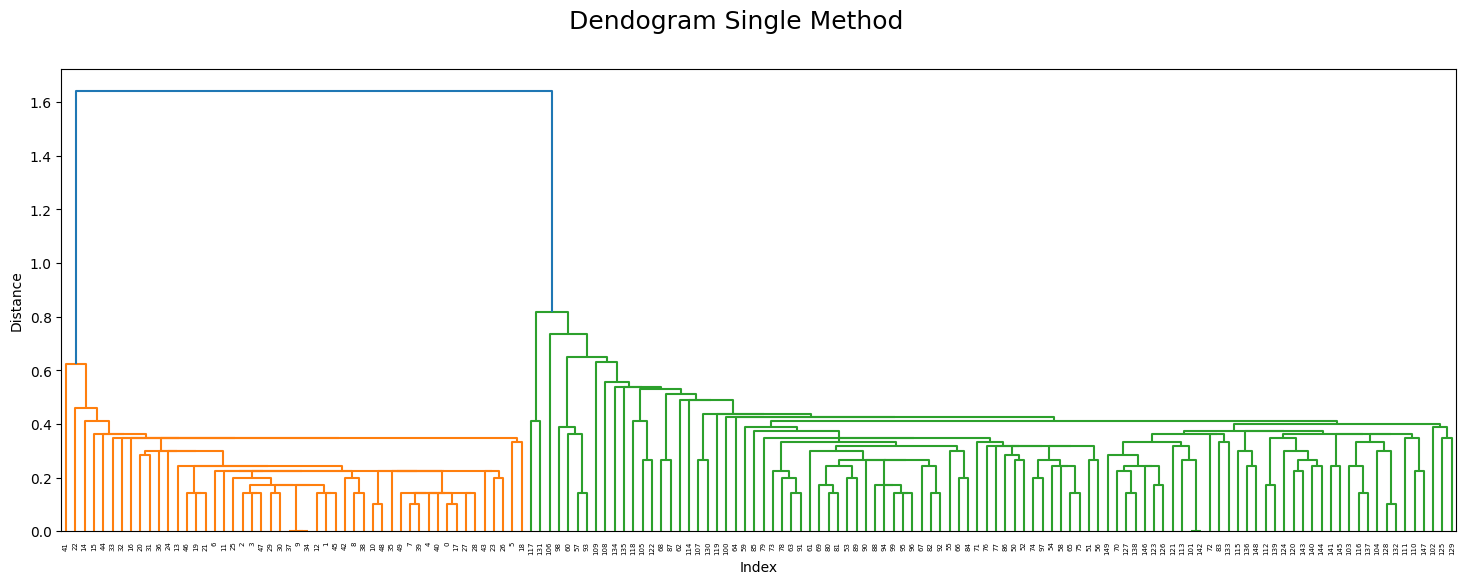

In [14]:
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage

df_iris = px.data.iris()

dist_sin = linkage(df_iris.loc[:,["sepal_length","sepal_width","petal_length","petal_width"]], method="single")
plt.figure(figsize=(18,6))
dendrogram(dist_sin, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendogram Single Method",fontsize=18)
plt.show()

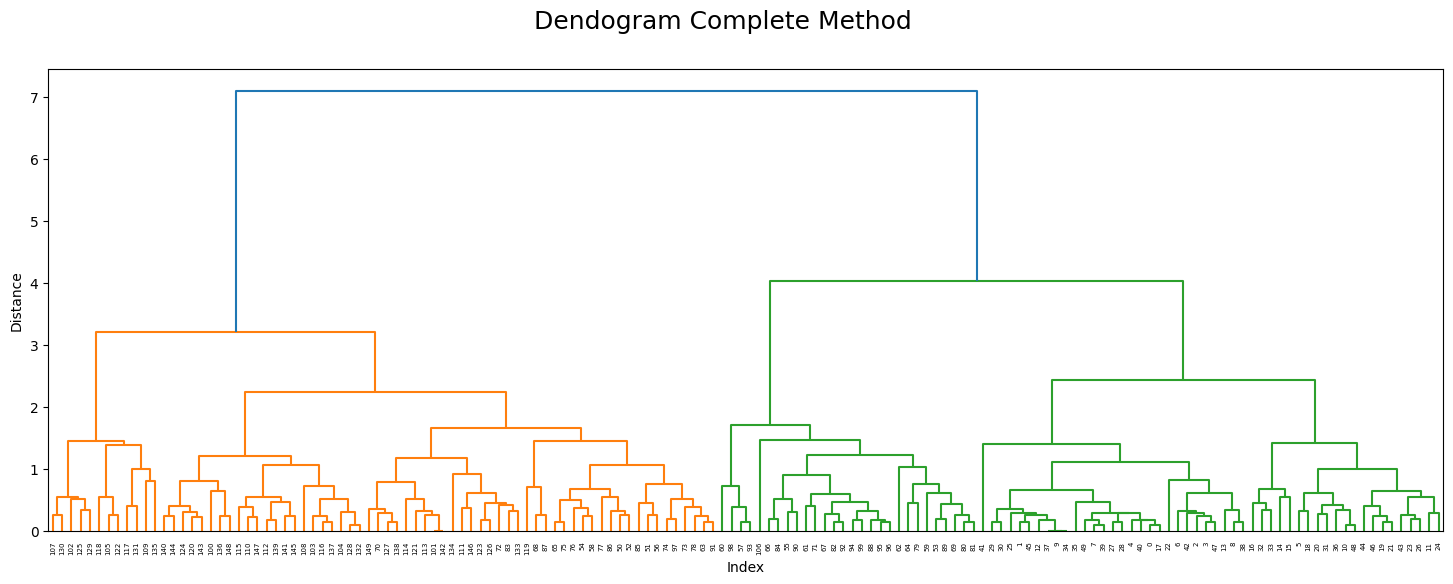

In [15]:
dist_comp = linkage(df_iris.loc[:,["sepal_length","sepal_width","petal_length","petal_width"]],method="complete")

plt.figure(figsize=(18,6))
dendrogram(dist_comp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendogram Complete Method",fontsize=18) 
plt.show()

## Example: Wine Dataset

**About Dataset**:
These data are the results of chemical analysis of wines grown in the same region of Italy, but obtained from three different varieties. As a result of the analysis, the amount of 13 components contained in each of the three types of wines was determined.

**About Features**:

| Name             | Description                                          | 
|------------------| -----------------------------------------------------|
| **Alcohol**          | Percentage of alcohol in wine. This parameter measures the quantitative ethanol content of the wine and affects its strength.|
| **Malic Acid**       | The amount of malic acid in wine. Malic acid gives wine freshness and brightness.                                     |
| **Ash**       | The amount of minerals (ash) in wine after the water has evaporated and the residues have been burned. It reflects the minerality of the wine.|
| **Alcalinity of Ash**       | Alkalinity of ash in wine. Alkalinity measures the pH level of a wine and affects its flavor profile.|
| **Magnesium**       |Amount of magnesium in wine. Magnesium is one of the trace elements that can affect the taste and aroma of wine.|
| **Total Phenols**       |The total amount of phenolic compounds in wine. Phenols are antioxidants and can affect the taste and color of wine.|
| **Flavanoids**       |The amount of flavonoids in wine. Flavonoids are also phenolic compounds and can contribute to the flavor and color of wine and also have antioxidant properties.|
| **Nonflavanoid Phenols**       |Amount of non-flavonoid phenolic compounds in wine.|
| **Proanthocyanins**       |The amount of proanthocyanidins in wine. Proanthocyanidins also belong to the group of phenolic compounds.|
| **Color Intensity**       |The color intensity of a wine is measured as the absorption of light at a specific wavelength. This parameter is related to the depth of color of the wine.|
| **Hue**       |The shade of a wine is measured on a color scale. This value can range from orange to purple and is related to the color subtlety of the wine.|
| **OD280/OD315 of Diluted Wines**       |The optical density of wine at a specific wavelength. This parameter may be related to the wine's content of anthocyanins (pigments that give wine its red color).|
| **Proline**       |The amount of amino acid proline in wine. Proline can affect the texture and structure of wine.|the texture and structure of wine.


In [16]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.figure_factory as ff

#Importing dataset
df_wine = pd.read_csv("assets/wine-clustering.csv")
df_wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Let's see the **correlation matrix** of a dataset.

Correlation matrix shows how much the features have a linear relationship (that is, whether the feature is a linear combination of another feature or not).

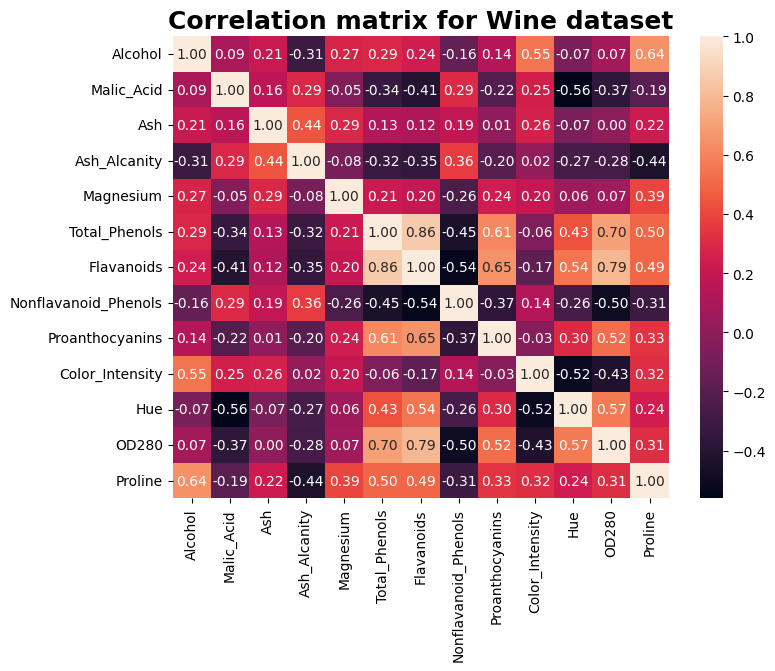

In [17]:
corr  = df_wine.corr()

fig = plt.subplots(figsize = (8,6))
sns.heatmap(corr, annot = True, fmt='.2f')
plt.title('Correlation matrix for Wine dataset', fontsize = 18, fontweight = 'bold')
plt.show()

The ***highest** correlation coefficient* is **0.86**, that is, as *Total_Phennols* increases, *Flavanoisd* increases.

There is also a ***negative correlation*** between some features (that is, a decrease in one feature entails an increase in another and vice versa).

Overall, the correlation between features is mostly in the range of -0.2 to 0.3.

Since there is no such thing as multicollinearity in this set, we will not remove variables and will work with the full data set.

#### Standardization of features

In [18]:
scaler = StandardScaler()
df_2 = scaler.fit_transform(df_wine)

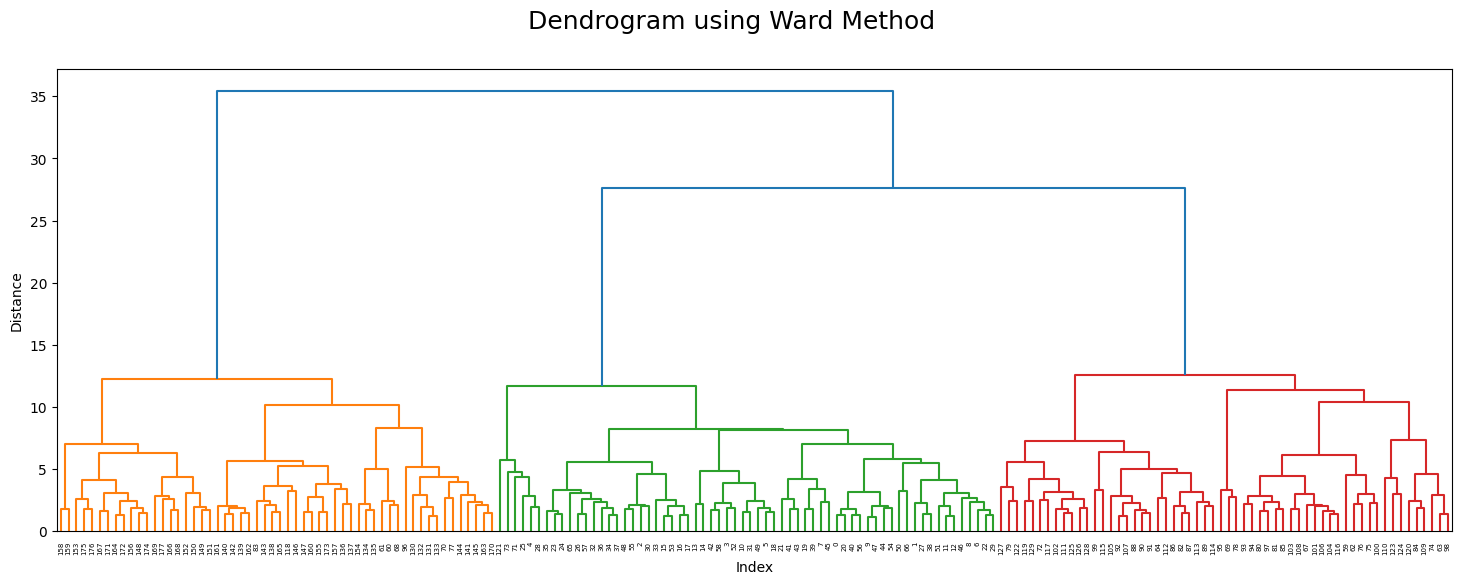

In [19]:
dist_comp = linkage(df_2, method="ward")

plt.figure(figsize=(18,6))
dendrogram(dist_comp, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("Dendrogram using Ward Method", fontsize=18) 
plt.show()

The Ward's method seeks to minimize the increase in the total within-cluster variance after merging clusters. It tends to form clusters with more uniform dispersion within the cluster. As can be seen from this dendrogram, it is best to divide this data set into 3 clusters (that is, define 3 classes). We will identify a model that will have the following hyperparameters:

**n_clusters = 3, linkage = 'ward'**

And let's make a plot to see our clusters:

In [20]:
import hvplot.pandas
import panel as pn
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 3, linkage ='ward')

y_hc = hc.fit_predict(df_wine)
df_wine['cluster'] = pd.DataFrame(y_hc)

x = pn.widgets.Select(name='x', value='Proline',
                      options=['Alcohol', 'Malic_Acid','Ash','Ash_Alcanity',
                               'Magnesium','Total_Phenols', 'Flavanoids', 
                               'Nonflavanoid_Phenols', 'Proanthocyanins','Color_Intensity','Hue',
                               'OD280', 'Proline'])
y = pn.widgets.Select(name='y', value='Color_Intensity',
                      options=['Alcohol', 'Malic_Acid','Ash','Ash_Alcanity',
                               'Magnesium','Total_Phenols', 'Flavanoids', 
                               'Nonflavanoid_Phenols', 'Proanthocyanins','Color_Intensity','Hue',
                               'OD280', 'Proline'])

kind = pn.widgets.Select(name='kind', value='scatter', 
                         options=['scatter'])

by_cluster = pn.widgets.Checkbox(name='cluster', value = True)
color = pn.widgets.ColorPicker(value='#0000ff')

@pn.depends(by_cluster, color)
def by_cluster_name(by_cluster, color):
    return 'cluster' if by_cluster else color

plot = df_wine.hvplot(x=x, y=y, kind=kind, c=by_cluster_name, colorbar=True, width=600, title = 'Interactive plot to see clusters variation based on features')

pn.Row(pn.WidgetBox(x, y, kind, color, by_cluster), plot)

Row
    [0] WidgetBox
        [0] Select(name='x', options=['Alcohol', 'Malic_Acid', ...], value='Proline')
        [1] Select(name='y', options=['Alcohol', 'Malic_Acid', ...], value='Color_Intensity')
        [2] Select(name='kind', options=['scatter'], value='scatter')
        [3] ColorPicker(value='#0000ff')
        [4] Checkbox(name='cluster', value=True)
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

You're free to make experiments, and see how clusters look with each feature of dataset

#### Performance evaluation indices

**Silhouette Score**

Silhouette Score is a widely used metric to evaluate the quality of clustering results. It measures how similar a data point is to its own cluster compared to other clusters. The score ranges from -1 to 1, with a higher value indicating better clustering performance.

**Kalinski-Harabasz Index**

The Kalinski-Harabasz index, also known as the coefficient of variance test, is another metric to evaluate clustering performance. It measures the ratio of variance between clusters to variance within a cluster. A higher Kalinski-Harabasz index value indicates better clustering performance with higher separation between clusters and less variance within clusters.

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

hc.fit(df_wine)
labels = hc.labels_
labels

silhouette = silhouette_score(df_wine, labels)
chi = calinski_harabasz_score(df_wine, labels)
print('Silhouette Score', round(silhouette,3))
print('Kalinski-Harabasz Index', round(chi,3))

Silhouette Score 0.564
Kalinski-Harabasz Index 552.856
